### Mixed metaheuristic algorithm

Z uporabo metahevrističnega algoritma preverjamo našo hipotezo o grafih z največjo sigma nepravilnostjo.

Ta algoritem je mešanica algoritmov SA in VNS

In [1]:
# importing necessary libraries
import random
import math
from itertools import combinations

# function for generating random neighbour of graph G
def random_neighbour(G, K):
    # choose option ( delete, add)
    options = [(0, 1), (1, 0), (1, 1), (2, 1), (1, 2), (2, 2)]
    d, a = options[K]

    # get node
    N = G.vertices()[randrange(G.order())]

    # remove d edges from n (if possible)
    for f in range(d):
        if len(G.neighbors(N)) != 0:
            G.delete_edge(N, G.neighbors(N)[randrange(len(list(G.neighbors(N))))])
    
    # add up to a edges
    k = 0 # max number of iterations counter
    j = 0 # counter for number of added edges
    while k < 8 and j < a:
        k += 1
        # new node
        V = G.vertices()[randrange(G.order())]
        if V == N or V in G.neighbors(N): # if node is N or is already connected to N, we skip it
            continue
        G.add_edge(N, V)
        
        # is triangle free
        if G.triangles_count() != 0:
            G.delete_edge(N, V) # if its not triangle free, we remove the edge that we added
        else: 
            j += 1
            continue

    return G # we return random neighbour

In [2]:
# sigma total irr, our f(s)
def sigma_irr(G):
    return sum((u - v) ** 2 for u, v in combinations(G.degree(), 2))

In [3]:
# mix SA and VNS - main function(our inital solution, number of neighborhoods, 
# number of tweaks, max. it, initial temperature, factor for T. decay)
def mix_SA_VNS(inital_G, k, m, max_iterations_without_improvement, T_0, alpha):
    G = inital_G.copy() # set G
    best = G.copy() # set current best
    num_of_it_without_improvement = 0 # counter for iterations without improvement
    T = T_0 # set initial temperature
    current_sigma_total_irr = sigma_irr(G)  # sigma value for current graph

    while num_of_it_without_improvement < max_iterations_without_improvement:
        
        # choose neighborhood
        j = randrange(k)

        # new solution m times
        G_mod = random_neighbour(G, j)

        for i in range(m-1):
            G_mod_mod = random_neighbour(G, j) # additional option

            # check if its better
            if sigma_irr(G_mod_mod) > sigma_irr(G_mod):
                G_mod = G_mod_mod.copy()

        # check, whether its better
        if sigma_irr(G_mod) > current_sigma_total_irr:
            G = G_mod # if it's better, set as current
            current_sigma_total_irr = sigma_irr(G) # update current sigma value
            num_of_it_without_improvement = 0 # reset counter for i.w.i.

        # choose worse option nonetheless with certain probability
        else:
            num_of_it_without_improvement += 1 # we didn't have improvement

            # get probability with Boltzmann distribution
            p = math.exp(-(current_sigma_total_irr - sigma_irr(G_mod)) / T)

            
            if random.random() < p: # accept change
                G = G_mod
                current_sigma_total_irr = sigma_irr(G)

        # check if its better than current best
        if sigma_irr(G) > sigma_irr(best):
            best = G.copy()

        # update Temperature
        T = alpha * T
        
    return best, G # return best solution and last option

### Pridobivanje prve rešitve

In [4]:
# generate star graph with max sigma total irr. (in center there can be multiple vertices)
def generate_max_sigma_star_graph(n):
    
    # generate star graph with or order n and c central vertices
    def generate_star_graph(n, c):
        graph = {} # dict. of neighbours
        i = 0
        for k in range(n): 
            i += 1
            if i <= c: # if vertex is central, set outer vertices as neighbors
                graph[k] = list(range(c, n))
            else: # else vertex is outer, set central vertices as neighbors
                graph[k] = list(range(c))
        
        return Graph(graph)


    max_sigma = 0 # for keeping maximum sigma value
    max_sigma_graphs = [] # list of graphs with maximum sigma value

    # check all graphs, where number of central nodes varies
    for c in range(1, round(n/2)):
        G = generate_star_graph(n, c) # get star graph
        sigma = sigma_irr(G) # get sigma value of star graph

        if sigma > max_sigma: # update if its the best
            max_sigma_graphs = [G]
            max_sigma = sigma
        elif sigma == max_sigma: # if equal, just append
            max_sigma_graphs.append(G)
    
    return max_sigma_graphs # return all graphs with max sigma value

### Poganjanje algoritmov - zaenkrat samo testiranje

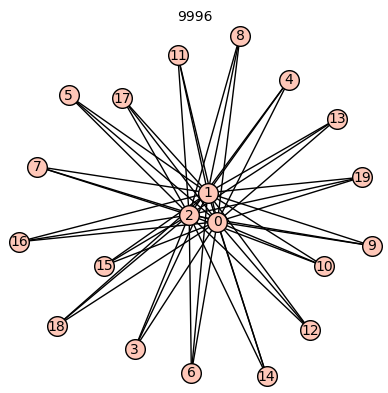

9996 4824
9996 3116
9996 3244
9996 2384
9996 3876


In [8]:
n = 20

K = 6
m = 5
alpha = .6
initial_G = generate_max_sigma_star_graph(n)
initial_G[0].show(title=f"{sigma_irr(initial_G[0])}")
T_0 = 1000
max_iterations_without_improvement = 5

for i in range(5):
    Best, G = mix_SA_VNS(initial_G[0], K, m, max_iterations_without_improvement, T_0, alpha)
    #G.show(title=f"{sigma_irr(G)}")
    print(sigma_irr(Best), sigma_irr(G))